# Data Randomization Tests

## Packages and Presets

In [20]:
#Note Paul: I could only execute these imports in the miniconda3 (Python 3.11.5) environment

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from torchvision import models
import os
from torchvision.datasets import ImageFolder
from sklearn.utils import shuffle
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from skimage.transform import resize
from captum.attr import visualization as viz
import os


# confusion matrix:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# append grandparent directory to path to make sure we can access the utils file
import sys

sys.path.append("../..")
from utils.utils import (
    get_pneumonia_images,
    PneumoniaDataset,
    set_all_seeds,
    train_and_validate,
    test,
    EarlyStopping,
)

import warnings
warnings.filterwarnings("ignore")

In [4]:
SEED = 42
VALIDATION_SIZE = 0.2

TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # use pretrained resnet 50
        self.resnet = models.resnet50(pretrained=True)
        # replace fully connected layer
        self.resnet.fc = nn.Sequential(
            nn.LazyLinear(2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            # return one output for binary classification with BCEWithLogitsLoss
            nn.Linear(2048, 2),
        )

    def forward(self, x):
        # squeeze to make sure dimension is compatible with BCEWithLogitsLoss
        return self.resnet(x)


## Loading the Data

In [6]:

path = r"C:\Users\pauls\Desktop\Studium\Machine Learning for Health Care\Projekt 1\heart_failure\archive\chest_xray"

train_images, train_labels = get_pneumonia_images(os.path.join(path, "train"))
val_images, val_labels = get_pneumonia_images(os.path.join(path, "val"))
test_images, test_labels = get_pneumonia_images(os.path.join(path, "test"))

# Since there are so few images (16 in total) in the validation set,
# we decided to first concatenate the train and validation images and then
# in a second step split this concatenated dateset into train and enlargened
# validation set. Further, we will make sure that the classes are similarly
# unbalanced in the validation set as in the training set. In the current
# validation set, this is not the case.
train_images_concat = train_images + val_images
train_labels_concat = np.concatenate([train_labels, val_labels])

# overwrite names for memory efficiency
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images_concat,
    train_labels_concat,
    test_size=VALIDATION_SIZE,
    random_state=SEED,
    stratify=train_labels_concat,
)


Reading NORMAL C:\Users\pauls\Desktop\Studium\Machine Learning for Health Care\Projekt 1\heart_failure\archive\chest_xray\train images:   0%|          | 0/1341 [00:00<?, ?it/s]

Reading NORMAL C:\Users\pauls\Desktop\Studium\Machine Learning for Health Care\Projekt 1\heart_failure\archive\chest_xray\train images: 100%|██████████| 1341/1341 [01:09<00:00, 19.32it/s]
Reading PNEUMONIA C:\Users\pauls\Desktop\Studium\Machine Learning for Health Care\Projekt 1\heart_failure\archive\chest_xray\train images: 100%|██████████| 3875/3875 [01:47<00:00, 36.04it/s]
Reading NORMAL C:\Users\pauls\Desktop\Studium\Machine Learning for Health Care\Projekt 1\heart_failure\archive\chest_xray\val images: 100%|██████████| 8/8 [00:00<00:00, 25.71it/s]
Reading PNEUMONIA C:\Users\pauls\Desktop\Studium\Machine Learning for Health Care\Projekt 1\heart_failure\archive\chest_xray\val images: 100%|██████████| 8/8 [00:00<00:00, 30.81it/s]
Reading NORMAL C:\Users\pauls\Desktop\Studium\Machine Learning for Health Care\Projekt 1\heart_failure\archive\chest_xray\test images: 100%|██████████| 234/234 [00:12<00:00, 19.21it/s]
Reading PNEUMONIA C:\Users\pauls\Desktop\Studium\Machine Learning for Hea

In [7]:
# randomize the labels of the training data only using np.permutation
# see https://github.com/adebayoj/sanity_checks_saliency/blob/master/src/train_cnn_models.py
np.random.seed(SEED)
train_labels_permuted = np.random.permutation(train_labels)


test_transforms = transforms.Compose(
    [transforms.CenterCrop(224), transforms.ToTensor()]
)

test_set = PneumoniaDataset(test_images, test_labels, transforms=test_transforms)

test_loader = DataLoader(
    test_set, batch_size=TEST_BATCH_SIZE, shuffle=False, pin_memory=True
)

In [8]:
# loss function that will be used for testing the model
num_0 = np.sum(train_labels_permuted == 0)
num_1 = np.sum(train_labels_permuted== 1)
weight = torch.tensor(
    [
        (1/num_0) * (num_0 + num_1) / 2.0,
        (1/num_1) * (num_0 + num_1) / 2.0
        
    ], dtype = torch.float32
).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight = weight)

## CNN with True Labels

In [7]:
# load the model
set_all_seeds(SEED)

cnn_not_permuted = CNN().to(DEVICE)
checkpoint = torch.load("../models/cnn_all_unfrozen.pth", map_location=DEVICE)
cnn_not_permuted.load_state_dict(checkpoint)

<All keys matched successfully>

In [8]:
test_loss, test_f1_score, test_balanced_accuracy, model_probs, y_true = test(
    cnn_not_permuted, test_loader, criterion, device=DEVICE
)

print(confusion_matrix(y_true, model_probs.round()))

Test Loss: 1.3815765224397183
Test F1 Score: 0.9050410316529894
Test Balanced Accuracy: 0.8303418803418803
[[157  77]
 [  4 386]]


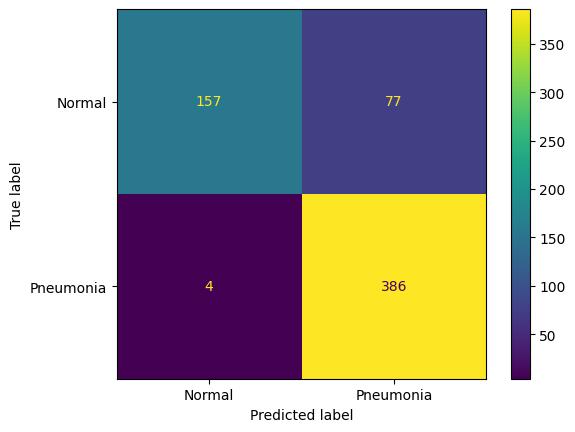

In [9]:
# Plot confusion matrix
labels = y_true
preds = model_probs.round()
cm  = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Pneumonia"])
disp.plot()

In [10]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)


print(f"Accuracy of the model is {accuracy:.2f}")
print(f"Balanced accuracy of the model is {test_balanced_accuracy:.2f}")
print(f"Recall of the model is {recall:.2f}")
print(f"Precision of the model is {precision:.2f}")
print(f"F1 Score of the model is {test_f1_score:.2f}")

Accuracy of the model is 0.87
Balanced accuracy of the model is 0.83
Recall of the model is 0.99
Precision of the model is 0.83
F1 Score of the model is 0.91


## CNN with Permuted Labels

In [9]:
# load the model
set_all_seeds(SEED)

path_model = r"C:\Users\pauls\Desktop\Studium\Machine Learning for Health Care\Projekt 1"

cnn_permuted = CNN().to(DEVICE)
checkpoint = torch.load(os.path.join(path_model, "cnn_permuted_all_unfrozen.pth"), map_location=DEVICE)
cnn_permuted.load_state_dict(checkpoint)

<All keys matched successfully>

In [10]:
test_loss, test_f1_score, test_balanced_accuracy, model_probs, y_true = test(
    cnn_permuted, test_loader, criterion, device=DEVICE
)

print(confusion_matrix(y_true, model_probs.round()))

Test Loss: 4.154295718669891
Test F1 Score: 0.7238723872387238
Test Balanced Accuracy: 0.5158119658119658
[[ 44 190]
 [ 61 329]]


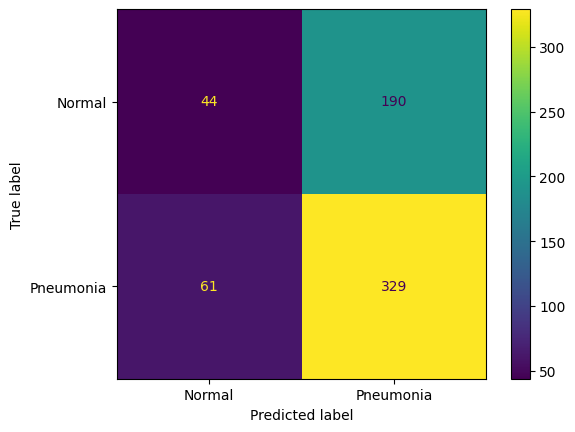

In [13]:
# Plot confusion matrix
labels = y_true
preds = model_probs.round()
cm  = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Pneumonia"])
disp.plot()

In [14]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)


print(f"Accuracy of the model is {accuracy:.2f}")
print(f"Balanced accuracy of the model is {test_balanced_accuracy:.2f}")
print(f"Recall of the model is {recall:.2f}")
print(f"Precision of the model is {precision:.2f}")
print(f"F1 Score of the model is {test_f1_score:.2f}")

Accuracy of the model is 0.60
Balanced accuracy of the model is 0.52
Recall of the model is 0.84
Precision of the model is 0.63
F1 Score of the model is 0.72


# GradCAM

In [75]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

path = r"C:\Users\pauls\Desktop\Studium\Machine Learning for Health Care\Projekt 1\heart_failure\archive\chest_xray"

test_dir = os.path.join(path, "test")

# define the transformation for the image
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# load the test dataset
test_dataset = ImageFolder(test_dir, transform=transform)

# Evaluate the model on a single image 
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    # return dataset.classes[preds[0].item()]
    return preds[0].item()

    # Pick five different images from the test dataset with label 0/1, and return the index


For the GradCAM visualisations below, we heavily leaned on the work done under the following link: https://pytorch.org/tutorials/beginner/introyt/captumyt.html
Below we will implement the GradCAM model through the CAPTUM package. We choose the last hidden convolutional layer as the layer to operate on.

In [76]:
last_conv_layer = cnn_permuted.resnet.layer4[-1]
layer_gradcam = LayerGradCam(cnn_permuted, last_conv_layer)

We choose here the same indices that we chose earlier at random for the integrated gradients. This way we can nicely compare the outputs of the GradCAM and the integrated gradients:

In [77]:
picked_indices_0 = [97, 17, 3, 111, 38, 34]
picked_indices_1 = [262, 251, 328, 247, 320, 303]

We start off by plotting from picked_indices_0, i.e. patients without the disease:

Predicted: 1


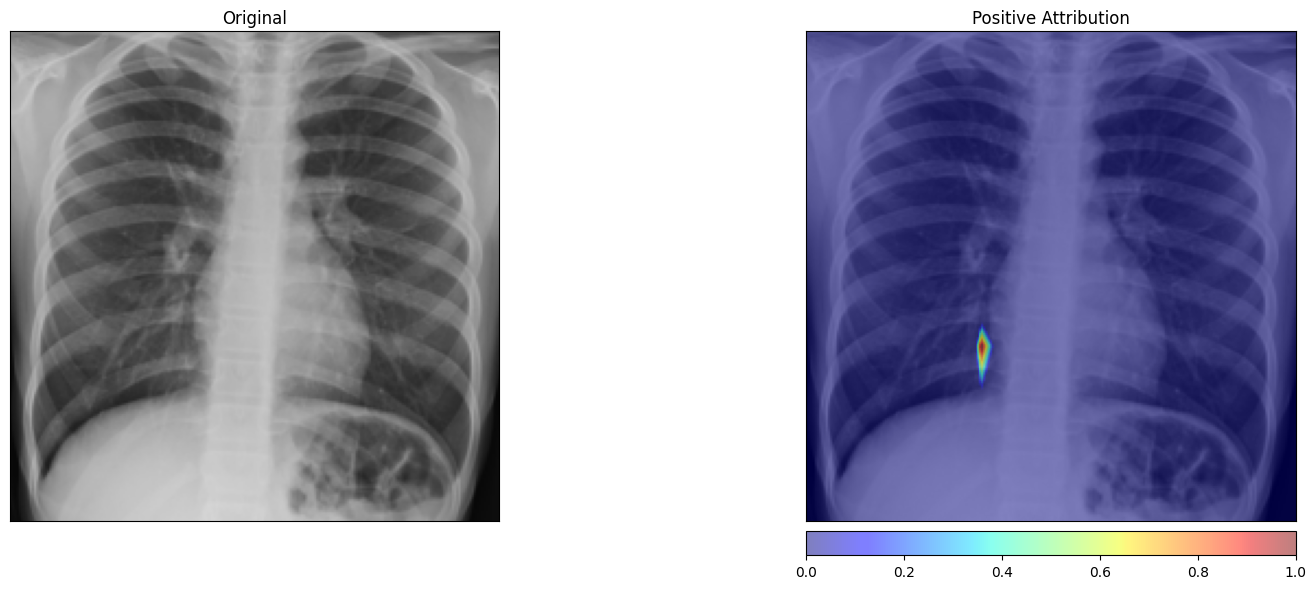

Predicted: 1


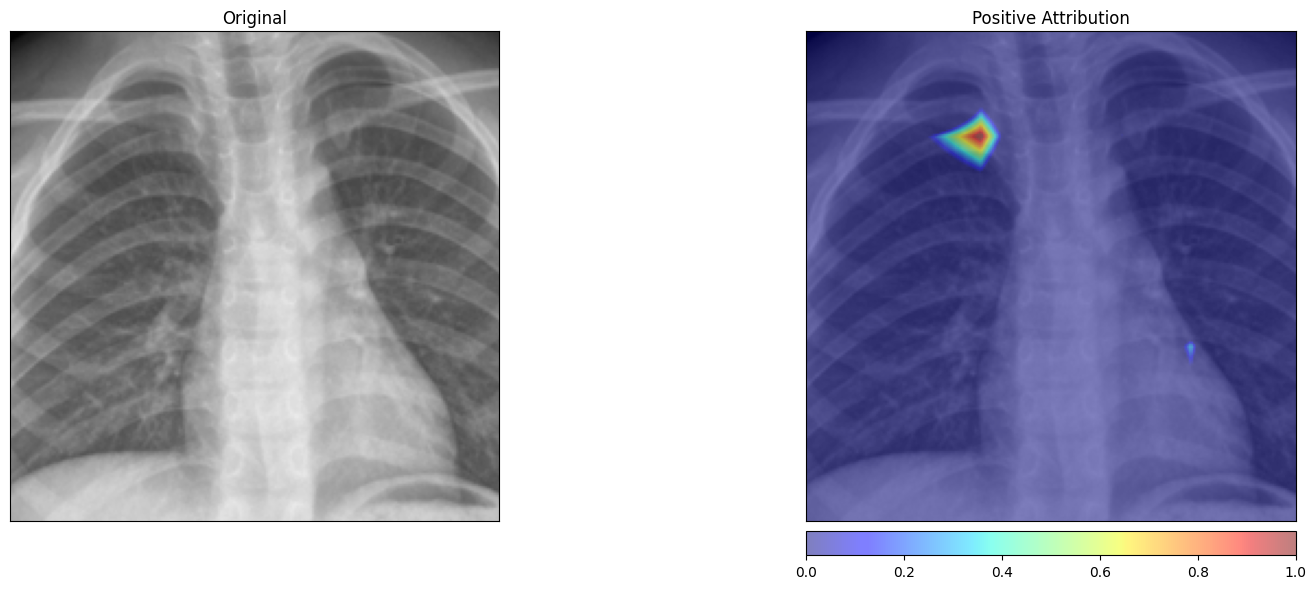

Predicted: 1


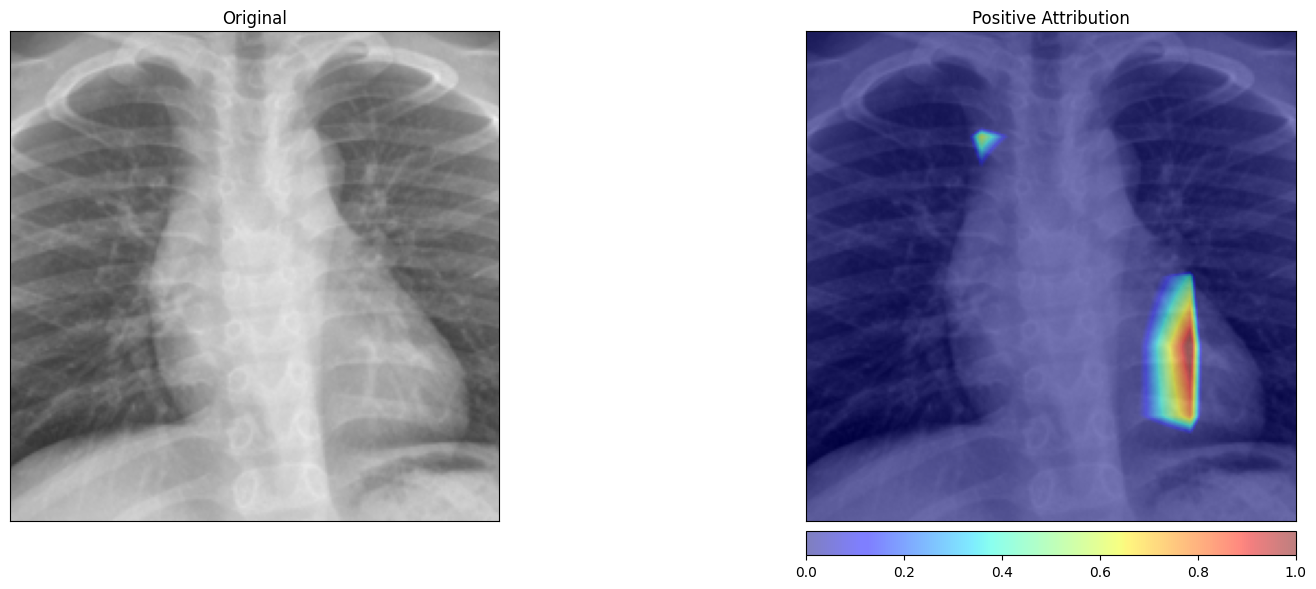

Predicted: 1


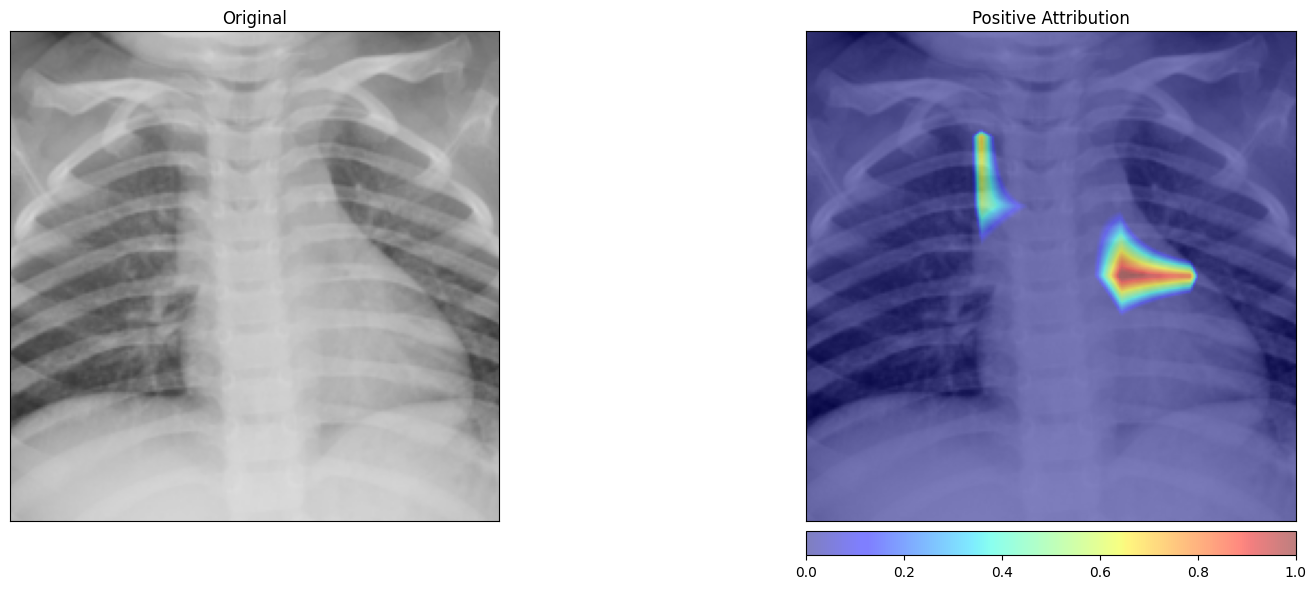

Predicted: 1


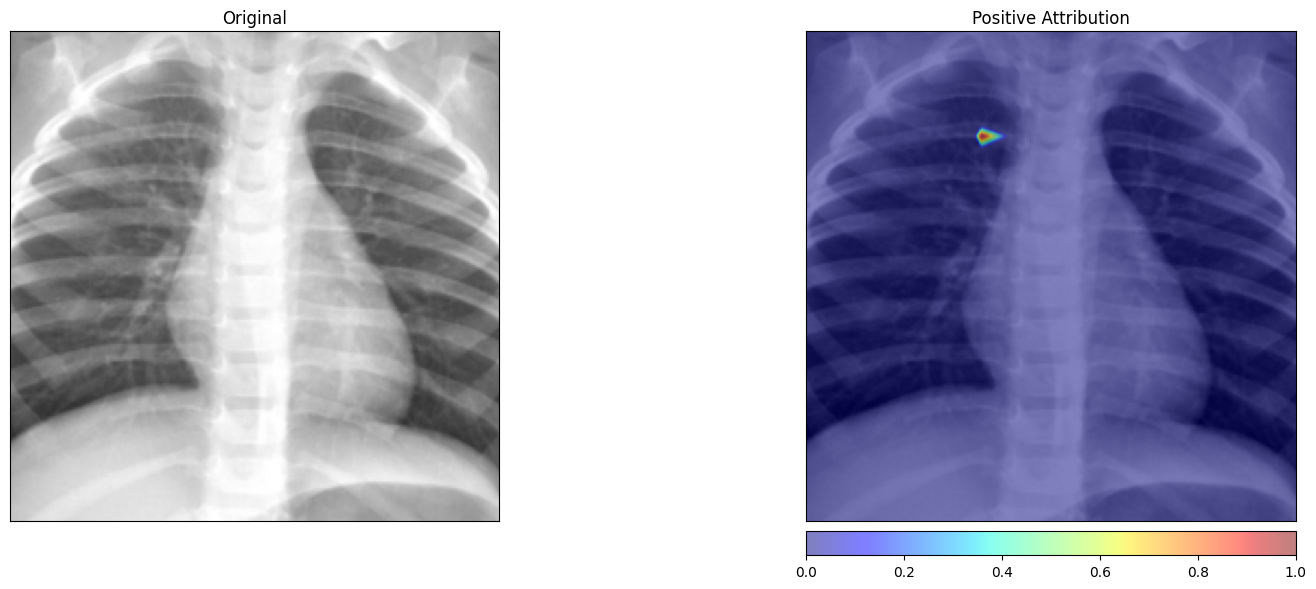

Predicted: 1


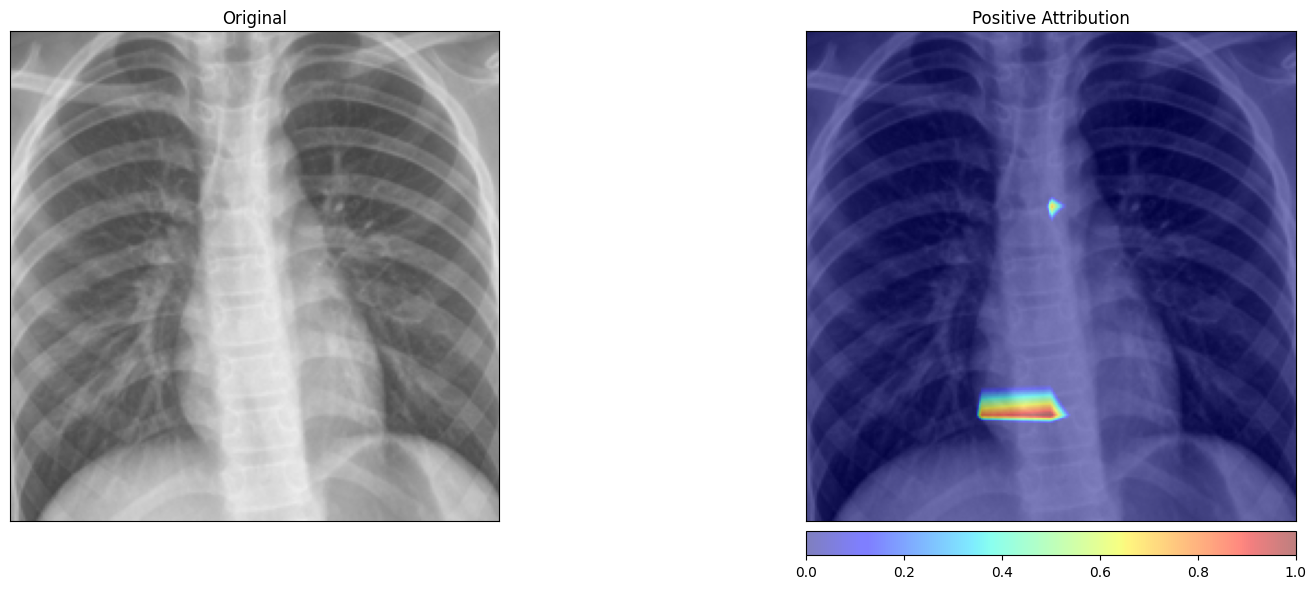

In [78]:
for i in picked_indices_0:
    img = test_dataset[i][0]
    input_img=img.unsqueeze(0)
    pred_label_idx = predict_image(img, cnn_permuted)
    
    #Create the heatmap:
    attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx, attribute_to_layer_input=True)
    
    #This heatmap would be 7x7, so we have to rescale it:
    upsample=resize(attributions_lgc.squeeze(0).permute(1,2,0).detach().numpy(), (224,224), preserve_range=True)
    
    #We have to make some modifications so that it can be plugged into LayerAttribution.interpolate:
    torch_upsample = torch.from_numpy(upsample).permute(2,0,1)
    
    upsamp_attr_lgc = LayerAttribution.interpolate(torch_upsample.unsqueeze(0), input_img.shape[2:])
    
    print('Predicted:', pred_label_idx)
    _ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                        img.permute(1,2,0).numpy(),
                                        ["original_image","blended_heat_map"],
                                        ["all","positive"],
                                        show_colorbar=True,
                                        titles=["Original", "Positive Attribution"],
                                        fig_size=(18, 6),
                                        cmap='jet')    

Predicted: 1


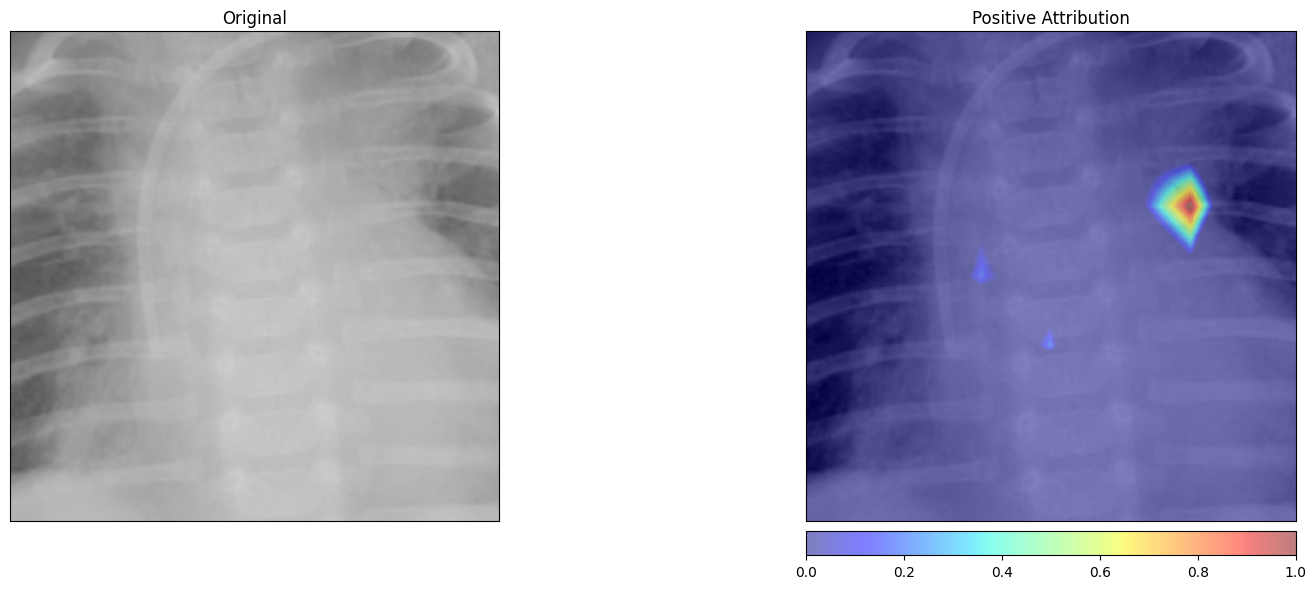

Predicted: 1


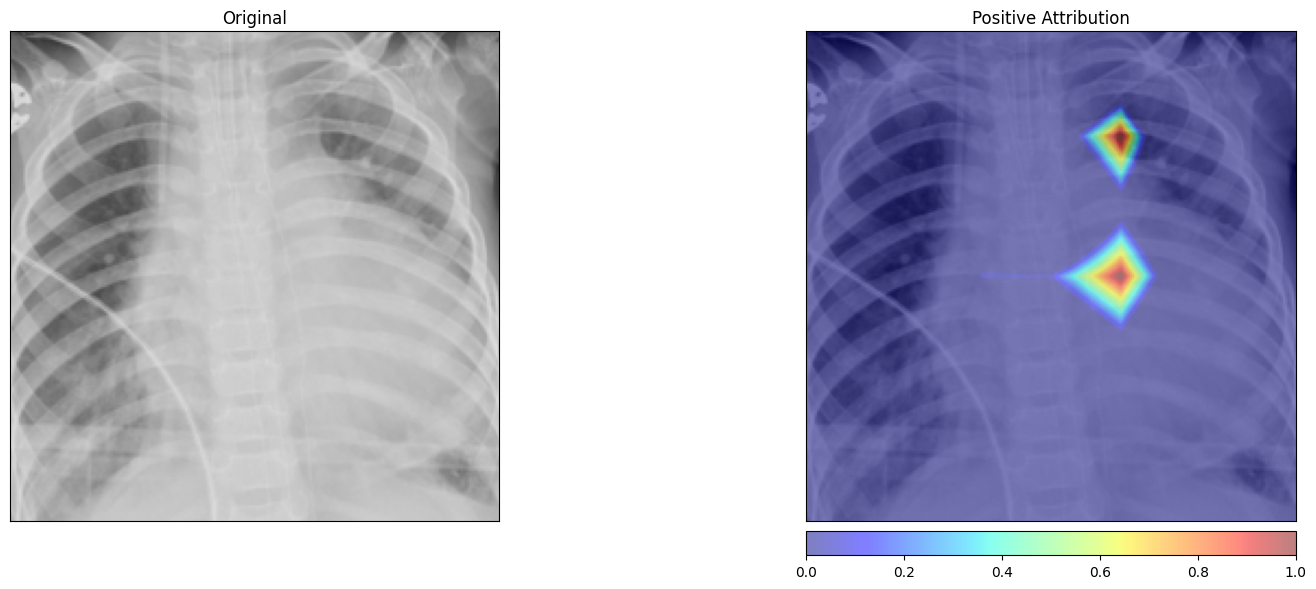

Predicted: 1


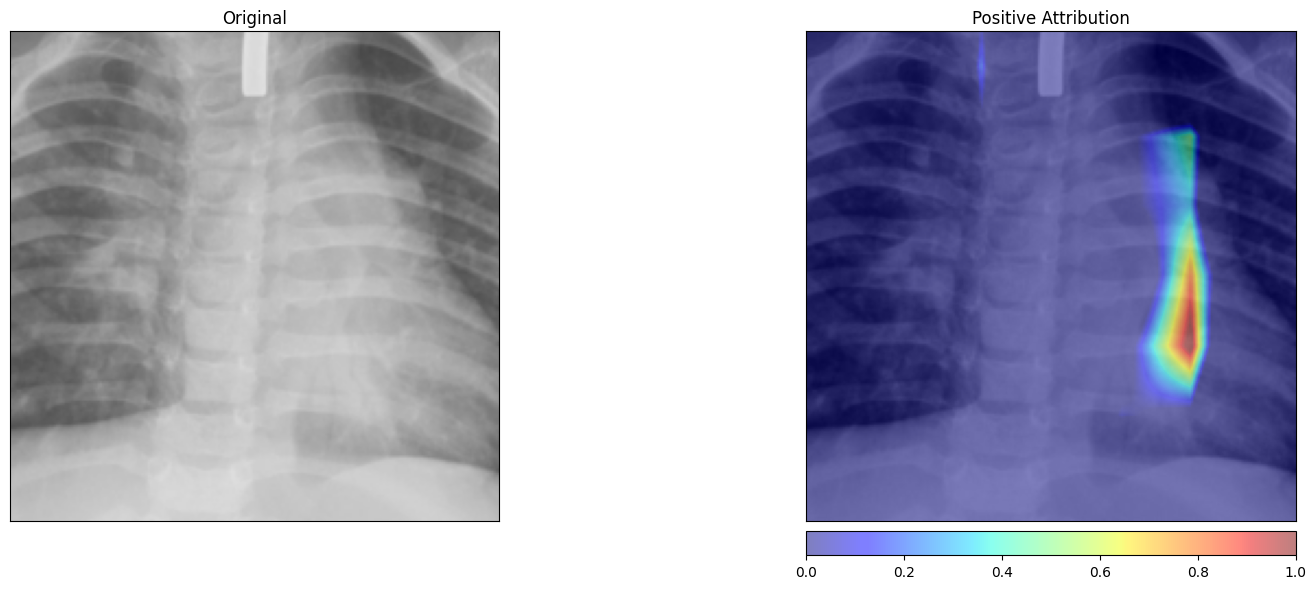

Predicted: 1


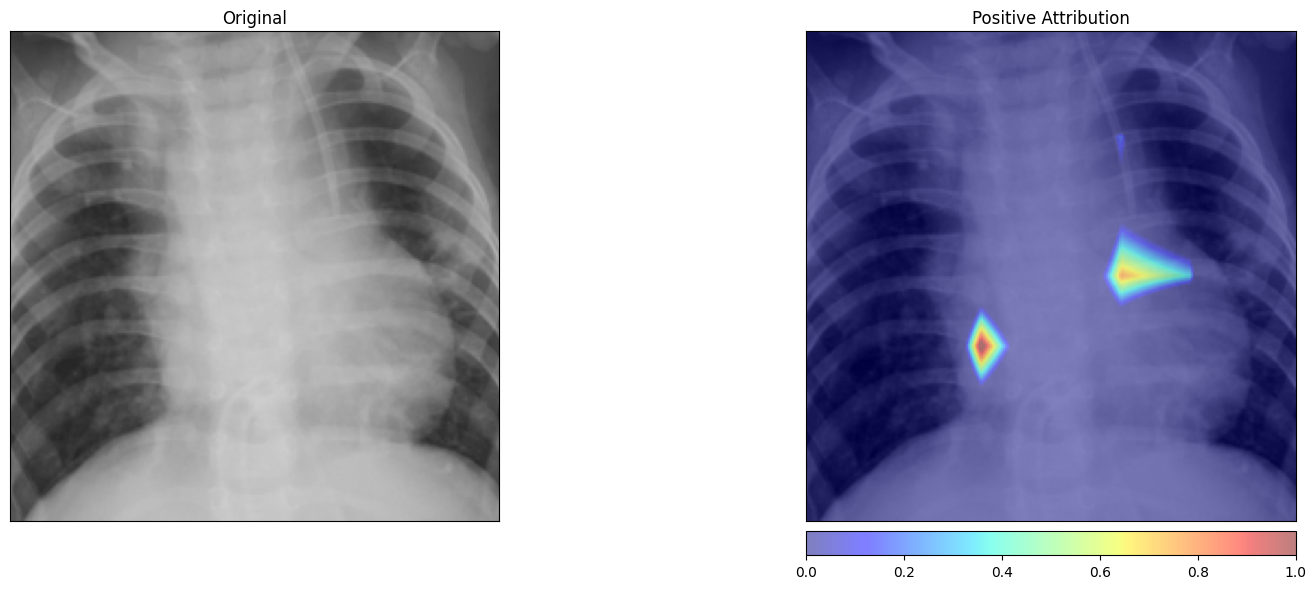

Predicted: 1


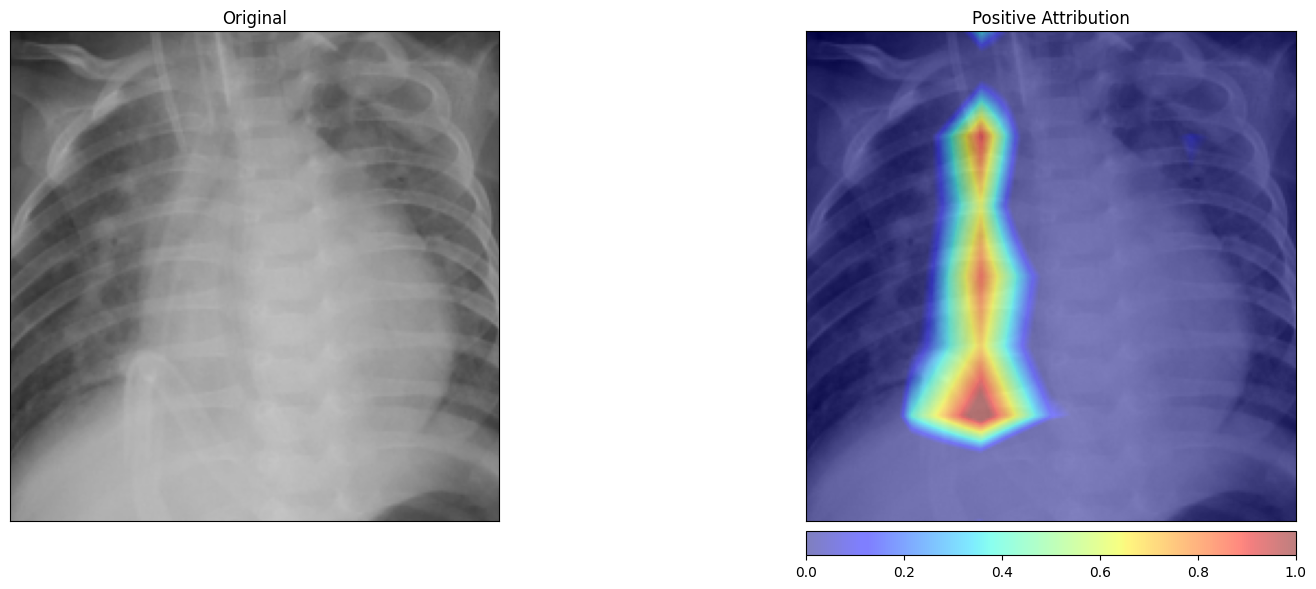

Predicted: 0


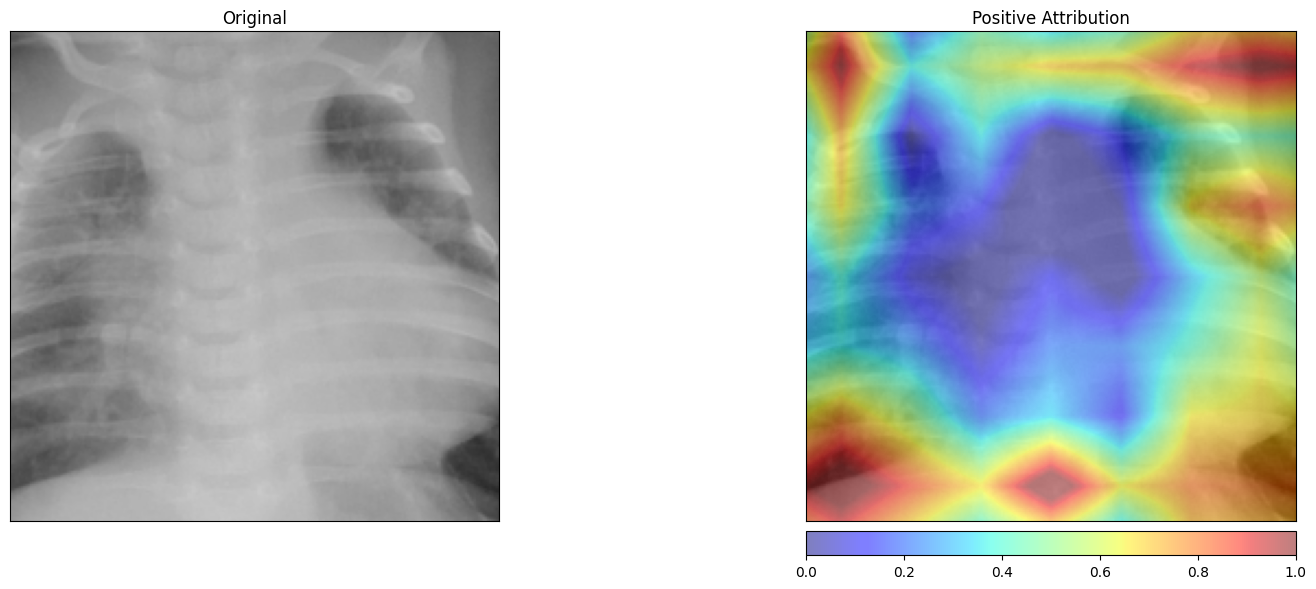

In [79]:
for i in picked_indices_1:
    img = test_dataset[i][0]
    input_img=img.unsqueeze(0)
    pred_label_idx = predict_image(img, cnn_permuted)
    
    #Create the heatmap:
    attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx, attribute_to_layer_input=True)
    
    #This heatmap would be 7x7, so we have to rescale it:
    upsample=resize(attributions_lgc.squeeze(0).permute(1,2,0).detach().numpy(), (224,224), preserve_range=True)
    
    #We have to make some modifications so that it can be plugged into LayerAttribution.interpolate:
    torch_upsample = torch.from_numpy(upsample).permute(2,0,1)
    
    upsamp_attr_lgc = LayerAttribution.interpolate(torch_upsample.unsqueeze(0), input_img.shape[2:])
    
    print('Predicted:', pred_label_idx)
    _ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                        img.permute(1,2,0).numpy(),
                                        ["original_image","blended_heat_map"],
                                        ["all","positive"],
                                        show_colorbar=True,
                                        titles=["Original", "Positive Attribution"],
                                        fig_size=(18, 6),
                                        cmap='jet')  
    
    